## Task 1: Data preparation
You are provided three files, i.e., text files containing bus logs of 3 different scenarios

1. CAN Bus log - injection of FFF as the speed reading
2. CAN Bus log - injection of RPM readings
3. CAN bus log - no injection of messages
Update your Python module to read the datasets were provided in assignment 1.

Unlike previous assignment, you will not use label data. You need to drop ‘Attack’ column from dataframe.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from typing import NamedTuple
from sklearn.ensemble import IsolationForest
from csv import reader
from pathlib import Path as p
import os


def getData(folder: str, filename: str):
    can_data = []  #List to store teh can data
    f = open(Path(folder) / filename)
    read_file = reader(f)
    file = list(read_file)
    speed = []
    rpm = []
    i = 0
    for row in file:
        row = str(row)
        record = {'stamp': row[3:20], 'PID': row[27:30], 'const1': row[31:35], 'change': row[35:43],
                  'value': int(row[43:47], 16), 'attack': 0}
        record["attack"] = 0  # Default is no attack

        #The PID of the speed is 254
        if record["PID"] == '254':  #Processing of speed
            if record["value"] >= 4095:
                record["attack"] = 1

            #The two lines below compute the speed from the last 4 bytes of the data frame
            record['value'] = (record['value'] * 0.62137119) / 100
            speed.append(record['value'])
            #print("i == ",i, "speed= ", record['value'])

        #The PID of RPM readings is 115
        if record["PID"] == '115':  #Processing of RPM
            if record["value"] >= 65535:
                record["attack"] = 1

            #The two lines below compute the RPM from the last 4 bytes of the data frame
            record['value'] = (record['value'] * 2)
            rpm.append(record['value'])
        i = i + 1
        can_data.append(record)
        record = {}

    f.close()
    can_data = pd.DataFrame(can_data)
    can_data['speed'] = pd.Series(speed)
    can_data['rpm'] = pd.Series(rpm)
    #The speed dataframe gives the sequence of the speed readings
    #The RPM dataset gives the sequence of RPM readings
    return can_data

In [2]:
# creating a class
class DataSet(NamedTuple):
    data: pd.DataFrame
    name: str

In [3]:
folder = 'D:\BitBucket/5214\Assignment 2\CAN Bus log/'
inj_speed = getData(folder=folder, filename='CAN Bus log - injection of FFF as the speed reading.log')
inj_rpm = getData(folder=folder, filename='CAN Bus log - injection of RPM readings.log')
no_inj = getData(folder=folder, filename='CAN Bus log - no injection of messages.log')
all_sets = [DataSet(inj_speed, 'inj_speed'), DataSet(inj_rpm, 'inj_rpm'), DataSet(no_inj, 'no_inj')]
inj_speed.head()

,stamp,PID,const1,change,value,attack,speed,rpm
0,1522028465.309906,264,0003,848C0100,32118.0,0,0.0,626.0
1,1522028465.310141,342,0027,073F0E00,14789.0,0,0.0,624.0
2,1522028465.310396,344,A5A1,B1A8459C,16384.0,0,0.0,624.0
3,1522028465.310662,40A,C102,39393738,12544.0,0,0.0,626.0
4,1522028465.310916,262,0800,08003253,40394.0,0,0.0,626.0


## Task 2 - k-mean Clustering
K-means clustering is one of the simplest and most popular unsupervised machine learning algorithms. A cluster refers to a collection of data points aggregated together because of certain similarities. You’ll define a target number k, which refers to the number of centroids you need in the dataset. A centroid is the imaginary or real location representing the center of the cluster. For this assignment you need to set k = 2 as we have 2 outcomes (i.e., Attack = 0 and Attack = 1)

You need to fit k-mean clustering separately for 6 datasets (1 Speed and 1 RPM dataframe for each of 3 scenarios).

1. Use scatter plot to show the fitted k-mean clusters.
2. Provide the centroids of each clusters.
3. Compare and discuss the scatter plots of the three scenarios from the speed datasets. Do the same for the RPM datasets.

In [4]:
# Super class for other models

class MyClass:
    def __init__(self, data: pd.DataFrame):
        self.data = data
        self.speed = self.equalize()['speed']
        self.rpm = self.equalize()['rpm']
        self.plot_folder = f'./Plots/{self.__class__.__name__}/'

    def equalize(self):
        '''This function takes average values of adjacent speed / rpm to equalize the numbers of speed and rpm in a data'''
        equalized_data = self.data[['speed', 'rpm']].dropna(how='all').reset_index()
        speed_count, rpm_count, = 0, 0
        speed_series, rpm_series = [], []
        for index, row in equalized_data.iterrows():
            if row['speed'] and np.isnan(row['rpm']):
                speed_count += 1
            elif row['rpm'] and np.isnan(row['speed']):
                rpm_count += 1
            else:
                speed_count += 1
                rpm_count += 1
                # Append the avg of both according to count
                speed_avg = np.average(equalized_data.loc[index - speed_count + 1: index + 1, 'speed'])
                rpm_avg = np.average(equalized_data.loc[index - rpm_count + 1: index + 1, 'rpm'])
                speed_series.append(speed_avg)
                rpm_series.append(rpm_avg)
                speed_count, rpm_count = 0, 0
        # Combine them to a DataFrame making sure they have equal length
        equalized_data = pd.DataFrame(zip(speed_series, rpm_series), columns=['speed', 'rpm'])
        # Drop last column if it has Nan
        equalized_data.dropna(how='any', inplace=True)
        return equalized_data

    def save_image(self, title):
        # Create a directory for saved images
        try:
            os.makedirs(self.plot_folder)
        except OSError:
            pass
        plt.savefig(fname=f'{self.plot_folder} {title}.png', format='png')

In [5]:
class MyKmeans(MyClass):
    def __init__(self, data: pd.DataFrame):
        super().__init__(data)

    def visualize_clusters(self, data, title, speed=True):
        data = data.values.reshape(-1, 1)
        kmeans = KMeans(n_clusters=2,
                        init='k-means++',  # Initialization method for kmeans
                        max_iter=50,  # Maximum number of iterations
                        n_init=50,  # Choose how often algorithm will run with different centroid
                        random_state=0)
        kmeans.fit(data)
        kmeans.predict(data)
        plt.scatter(data, np.zeros(shape=data.shape), color='b')
        plt.scatter(kmeans.cluster_centers_, np.ones(shape=kmeans.cluster_centers_.shape), color='r', lw=5)
        sub_title = 'speed' if speed else 'rpm'
        title = f"{title} in terms of {sub_title}"
        plt.title(title)
        self.save_image(title)
        plt.show()

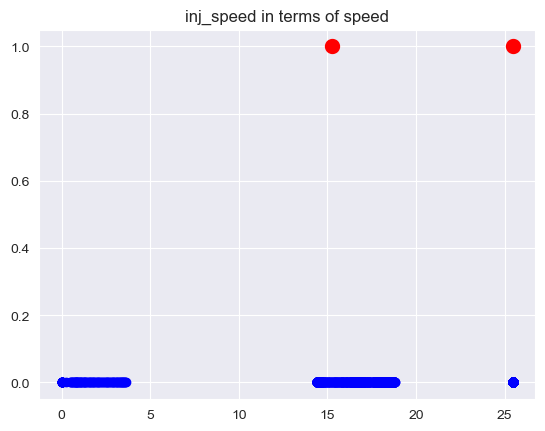

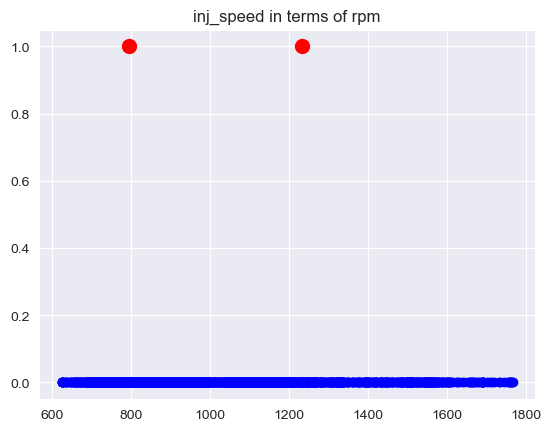

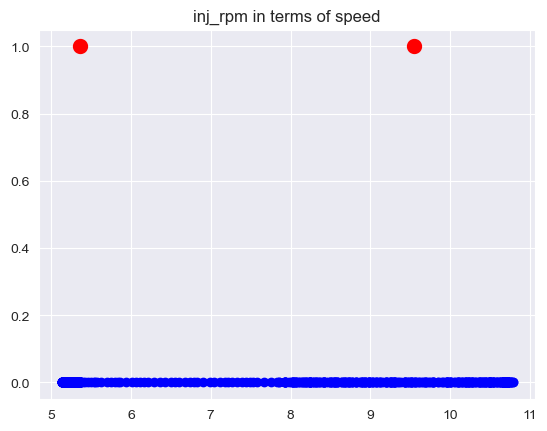

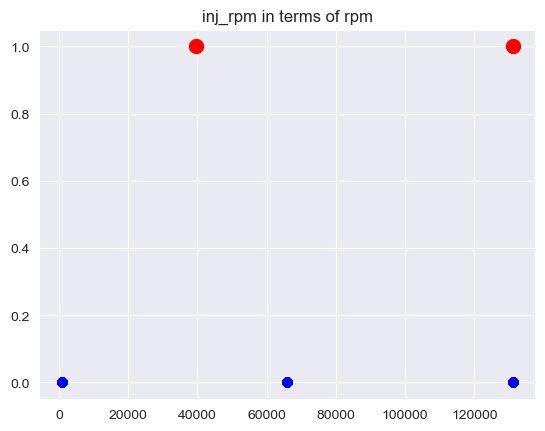

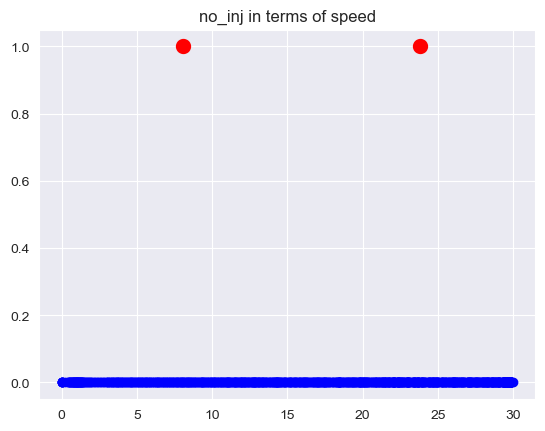

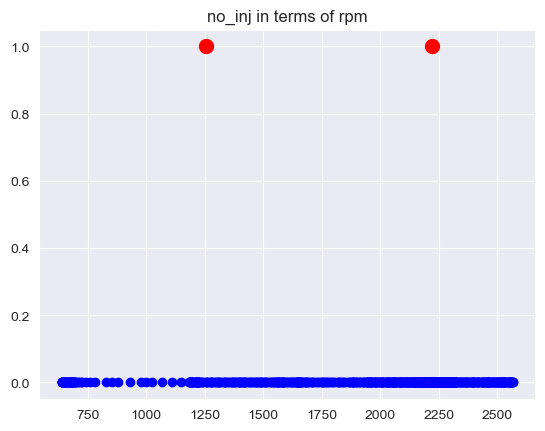

In [6]:
for set_ in all_sets:
    my_kmeans = MyKmeans(set_.data)
    my_kmeans.visualize_clusters(data=my_kmeans.speed, title=set_.name, speed=True)
    my_kmeans.visualize_clusters(data=my_kmeans.rpm, title=set_.name, speed=False)

## Task 3- Isolation Forest Algorithm
You need to fit Isolation Forest separately for the six datasets (1 Speed and 1 RPM data frame for each of the three scenarios).

1. Use scatter plot to show the fitted isolation forest clusters
2. Note down data point’s values (for example, RPM = 2700) detected as anomalies by IF.
3. Compare and discuss the scatter plots of the three scenarios from the speed datasets. Do the same for the RPM datasets.

In [7]:
class MyIS(MyClass):
    def __init__(self, data: pd.DataFrame):
        super().__init__(data)

    def visualize_clusters(self, data, title, speed=True):
        # data = data.values.reshape(-1, 1)
        if_ = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), max_features=1.0,
                              bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
        preds = if_.fit_predict(data.values.reshape(-1, 1))
        # -1 values are anomalous
        conditions = [True if predicted == -1 else False for predicted in preds]
        outliers = np.extract(conditions, data)
        normal = np.extract(np.invert(conditions), data)
        plt.scatter(outliers, np.zeros(shape=outliers.shape), color='r')
        plt.scatter(normal, np.ones(shape=normal.shape), color='b')
        sub_title = 'speed' if speed else 'rpm'
        title = f"Dataset {title}, outliers in red, normal in blue in terms of {sub_title}"
        plt.title(title)
        self.save_image(title)
        plt.show()
        print('Outliers are')
        print(outliers)

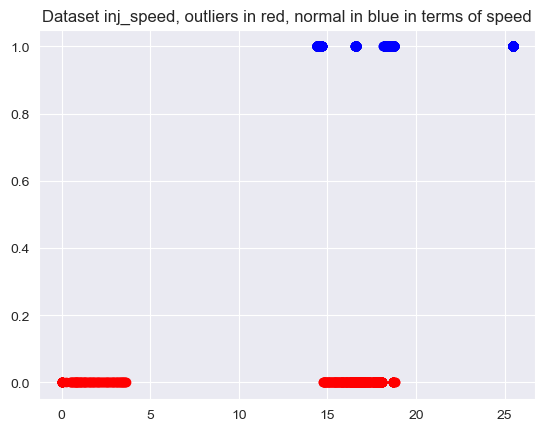

Outliers are
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.22680048  0.48777638  0.5219518   0.5219518   0.57476835
  0.64311918  0.65865346  0.69593573  0.74875228  0.76428656  0.7829277
  0.80156884  0.82020997  0.85438539  0.86991967  0.90409508  0.9382705
  0.97555277  1.01283504  1.04701046  1.08118587  1.11536129  1.1495367
  1.18371212  1.23652867  1.27381094  1.30798635  1.34216177  1.39497832
  1.44779487  1.48197029  1.53478684  1.57206911  1.60624453  1.65906108
  1.71187763  1.76158732  1.79576274  1.83304501  1.88586156  1.93867811
  1.99149466  2.04120436  2.07537977  2.12819633  2.18101288  2.21829515
  2.2711117   2.32082139  2.37363795  2.4264545   2.47927105  2.5320876
  2.58179729  2.63461385  2.6874304   2.74024695  2.77752922  2.83034577
  2.88005547  2.91423088  2.95151315  3.0043297   3.05714625  3.10

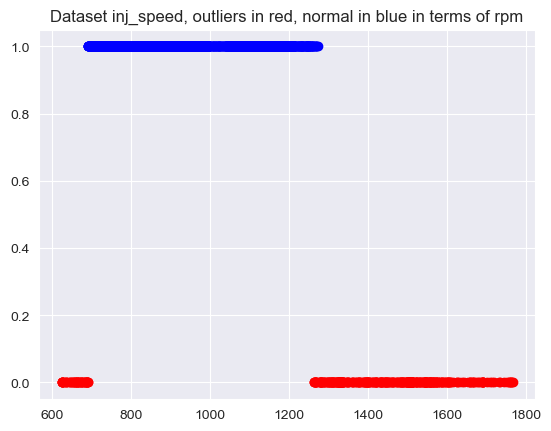

Outliers are
[ 625.  624.  625.  626.  626.  627.  628.  631.  634.  635.  636.  640.
  644.  646.  648.  651.  654.  657.  660.  662.  664.  666.  668.  672.
  676.  678.  680.  683.  686.  689.  690.  682.  674.  668.  662.  657.
  652.  655.  658.  663.  668.  672.  676.  682.  688.  688.  688.  688.
  690. 1270. 1281. 1289. 1292. 1300. 1308. 1312. 1319. 1326. 1331. 1340.
 1348. 1353. 1362. 1369. 1372. 1379. 1384. 1385. 1390. 1393. 1393. 1397.
 1398. 1396. 1399. 1401. 1401. 1404. 1406. 1409. 1412. 1413. 1418. 1421.
 1422. 1428. 1431. 1430. 1433. 1435. 1434. 1437. 1440. 1443. 1446. 1446.
 1450. 1452. 1449. 1451. 1454. 1456. 1463. 1471. 1476. 1479. 1482. 1490.
 1497. 1501. 1513. 1524. 1533. 1542. 1546. 1552. 1558. 1566. 1573. 1573.
 1574. 1573. 1569. 1565. 1560. 1559. 1557. 1552. 1547. 1544. 1546. 1547.
 1545. 1548. 1549. 1546. 1544. 1539. 1532. 1520. 1508. 1504. 1505. 1509.
 1510. 1506. 1506. 1505. 1500. 1500. 1504. 1509. 1511. 1510. 1514. 1515.
 1512. 1512. 1512. 1514. 1512. 1505. 1

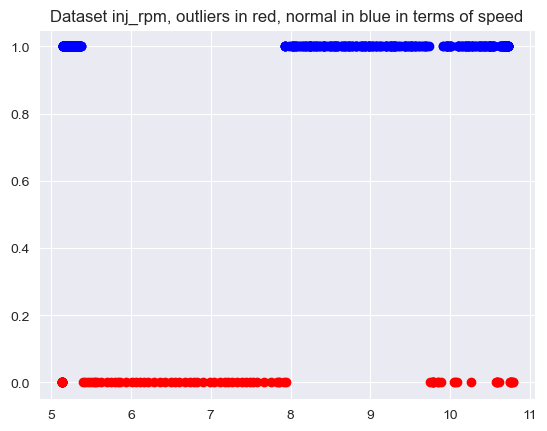

Outliers are
[ 5.13252603  5.13252603  5.13252603  5.13252603  5.13252603  5.13252603
  5.13252603  5.13252603  5.13252603  5.13252603  5.13252603  5.13252603
  5.13252603  5.13252603  5.13252603  5.13252603  5.13252603  5.13252603
  5.13252603  5.13252603  5.39660879  5.4307842   5.46806647  5.50224189
  5.5364173   5.55505844  5.57369957  5.62651613  5.69486696  5.74768351
  5.80050006  5.83467547  5.86885089  5.93720172  6.00865941  6.06147596
  6.11429251  6.16710906  6.21681876  6.28827644  6.35973413  6.42808496
  6.49643579  6.54925234  6.60206889  6.67352658  6.74498427  6.79469396
  6.82886938  6.90032706  6.98731903  7.04013558  7.11159327  7.1799441
  7.21411952  7.26693607  7.3352869   7.38810345  7.44092     7.49373655
  7.53101882  7.58383537  7.67082734  7.75781931  7.82617014  7.86034555
  7.86034555  7.9131621   9.78348939  9.85184022 10.06310642 10.58816508
 10.74350788 10.76214901 10.76214901 10.78079015 10.78079015 10.76214901
 10.74350788 10.60680621 10.58816508 10

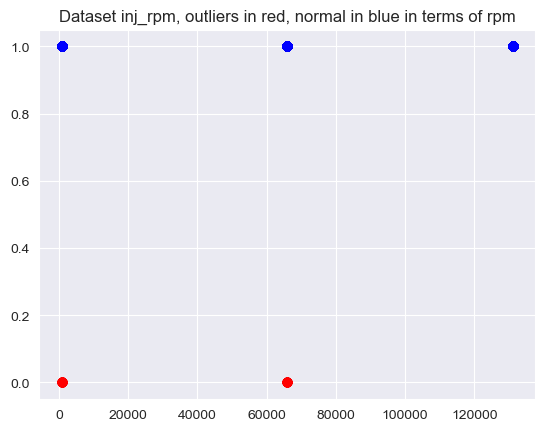

Outliers are
[  741.   740.   750.   747.   749.   747.   740.   738.   737.   736.
   736.   736.   739.   747.   741.   747.   750.   747.   747.   747.
   750.   750.   750.   750.   750.   750.   747.   740.   740.   741.
   741.   740.   738.   736.   737.   737.   736.   736.   736.   740.
   740.   740.   740.   741.   741.   740.   739.   738.   740.   750.
   747. 65911. 65911. 65911. 65911. 65910. 65910. 65910. 65910. 65911.
 65911. 65911. 65911. 65904. 65904. 65904. 65904. 65910. 65910. 65910.
 65910. 65910. 65910. 65910. 65910. 65904. 65904. 65903. 65903. 65903.
 65903. 65902. 65902. 65902. 65902. 65904. 65904. 65910. 65910. 65910.
 65910.]


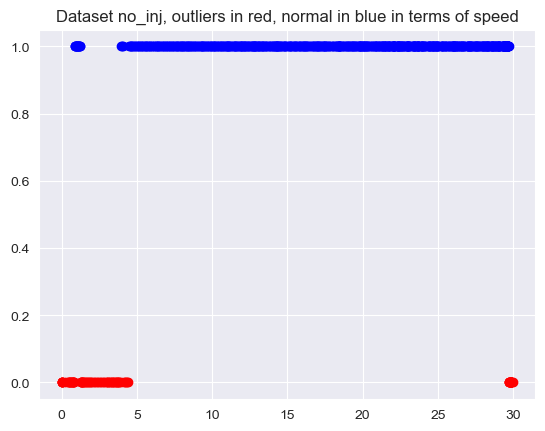

Outliers are
[ 0.          0.          0.          0.          0.          0.22680048
  0.45360097  0.45360097  0.48777638  0.54059294  0.55923407  0.57476835
  0.62447805  0.65865346  0.69593573  0.74875228  0.76428656  0.7829277
  0.80156884  0.82020997  1.2551698   1.27381094  1.30798635  1.34216177
  1.37944404  1.41361946  1.44779487  1.50061142  1.55342797  1.60624453
  1.67459536  1.74294619  1.81440387  1.9045027   1.97285353  2.04120436
  2.12819633  2.21518829  2.32082139  2.44509563  2.55072873  2.6377207
  2.7433538   2.84588005  2.96704743  3.09132167  3.19695477  3.31812215
  3.45793067  3.58220491  3.70337229  3.84318081  4.22532409  4.38377375
 29.73882515 29.72329087 29.75746629 29.84445826 29.82892398 29.76057315
 29.70775659 29.79474856 29.82892398 29.84445826 29.88174053 29.86620625
 29.76057315 29.72329087 29.84445826 29.93455708 29.95319821 29.84756511
  4.34649147  4.24396523  4.14143898  3.91153164  3.82453967  3.73754771
  3.66919688  3.56356377  3.43928954  3.

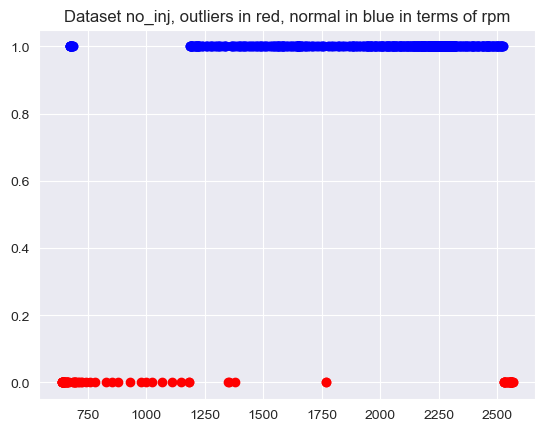

Outliers are
[ 638.  640.  639.  638.  639.  640.  642.  644.  644.  644.  645.  646.
  648.  650.  650.  650.  652.  654.  657.  660.  661.  662.  663.  664.
  668.  687.  688.  689.  694.  695.  696.  698.  707.  714.  720.  726.
  742.  758.  781.  829.  854.  879.  928.  976. 1000. 1023. 1069. 1111.
 1148. 1767. 2528. 2529. 2535. 2529. 2533. 2534. 2534. 2544. 2545. 2543.
 2552. 2556. 2558. 2556. 2553. 2559. 2559. 2558. 2562. 2560. 2558. 2565.
 2565. 2561. 2559. 2556. 2557. 2546. 2527. 1767. 1377. 1353. 1347. 1181.
 1182.]


In [8]:
for set_ in all_sets:
    my_is = MyIS(set_.data)
    my_is.visualize_clusters(data=my_is.speed, title=set_.name, speed=True)
    my_is.visualize_clusters(data=my_is.rpm, title=set_.name, speed=False)

Discussion:
* In terms of rpm
  * When rpm is injected, the outliers look overlapping with normal values, which is not convincing
  * When speed is inject, the outliers are on both ends, but the upper end seems to outnumber the lower one while the normal is of the same amount.
  * When no injection, opposite with the middle scenario, the normal values are skewed to the upper values while the outliers are more on the lower end.
* In terms of sped
  * When rpm is injected, the outliers focus more from the middle to the lower bound while the normal values are on the other side. Both amounts are roughly the same.
  * When speed is inject, the outliers clearly outnumber the normal values. However, the formers are not on other ends, which is not convincing.
  * When no injection, the outliers are almost at 15-18% lowest of the entire dataset, together with a peak at the other end.

In the scenarios of injection, the centroids are at strange locations. Another potential explanation is that the centroids also depend on random initialization.

## Task 4 - Discussion
Write 1-2 paragraphs reflecting on what you have learnt from this assignment. Questions that you may consider are: What were the shortcomings of using unsupervised ML on this problem? What could be done to make the models perform better? What do you suggest doing to solve the problem better?

While KMeans is easily understandable, has linear time complexity, interpretable result, it can only work with linear clusters while the performance significantly depends on the initial clusters and k. My suggestion is to hypertune this. If we have to consider a similar model, try DBScan as it can work well with non-linear data.
Isolation Forest is based on the decision tree algorithm; hence it is easily understandable. We can not only detect anomalies faster but we also require less memory compared to other algorithms. It works fairly good in the real case. To improve, searching algorithms with hyperparameters can support if time is available.
Another approach I suggest is to try different algorithms with Random Search.

## Task 5 - Hidden Harkov Models (10 optional points):
Build Hidden Markov Model to predict Attack vs no Attack.